In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalAveragePooling1D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional, MultiHeadAttention, LayerNormalization, BatchNormalization, Add
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.models import Model
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json
import numpy as np


In [10]:
image_path = "../input/flickr8k/Images"
data = pd.read_csv("../input/flickr8k/captions.txt")

data = data.reset_index(drop=True)


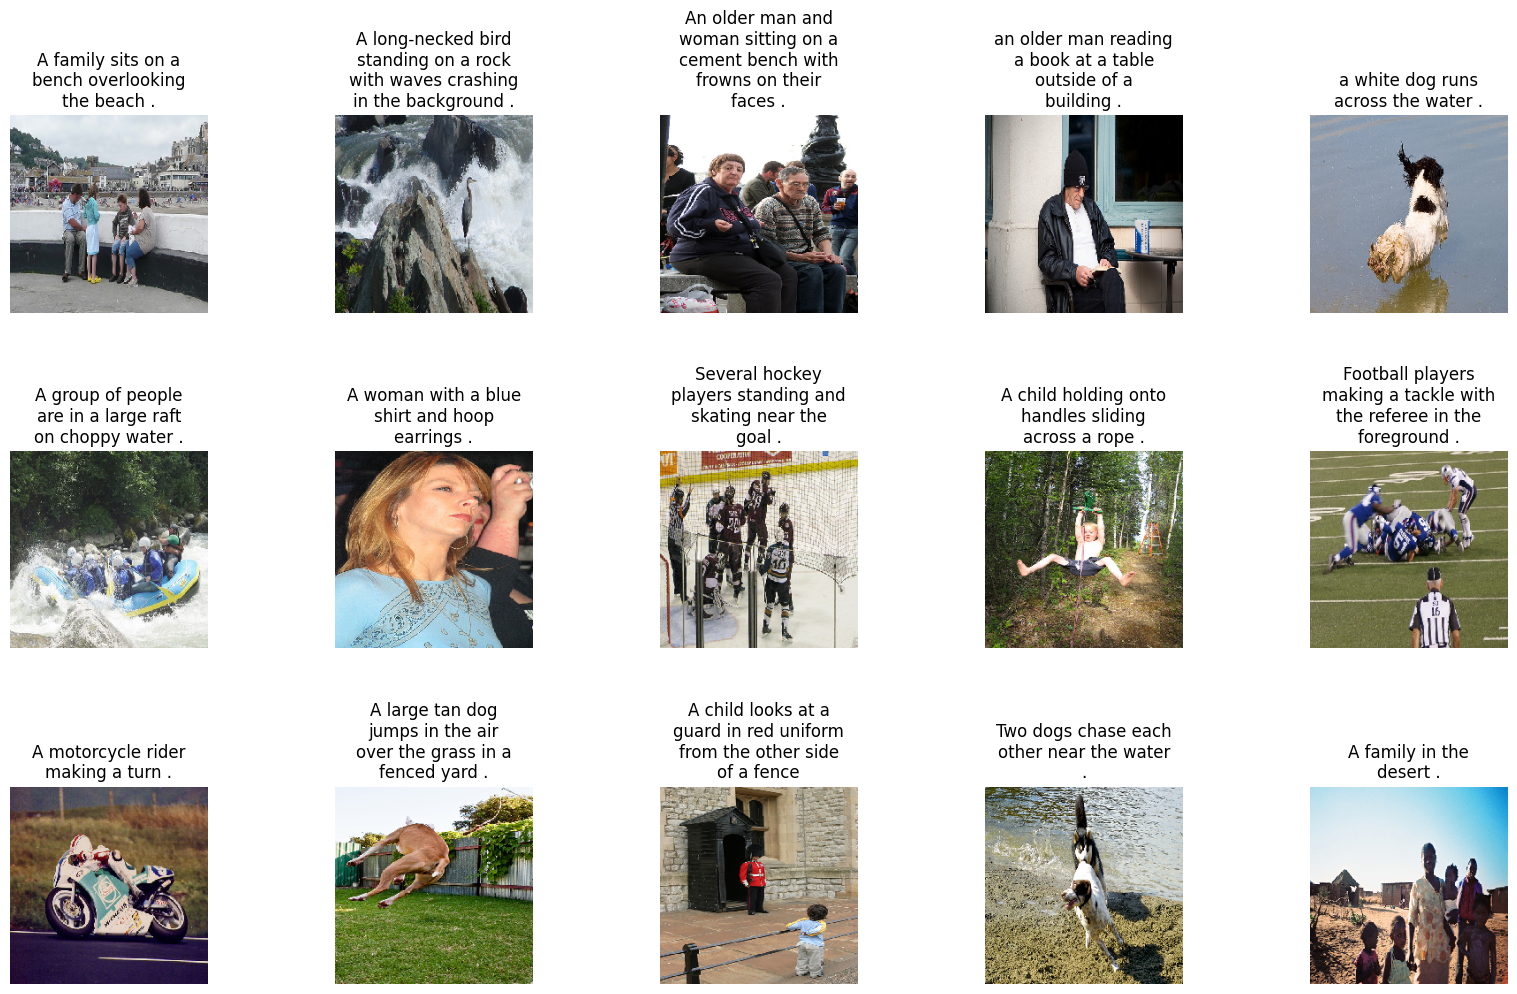

In [5]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

display_images(data.sample(15))


In [6]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "<sos> "+data['caption']+" <eos>"
    return data

data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]


['<sos> child in pink dress is climbing up set of stairs in an entry way <eos>',
 '<sos> girl going into wooden building <eos>',
 '<sos> little girl climbing into wooden playhouse <eos>',
 '<sos> little girl climbing the stairs to her playhouse <eos>',
 '<sos> little girl in pink dress going into wooden cabin <eos>',
 '<sos> black dog and spotted dog are fighting <eos>',
 '<sos> black dog and tri-colored dog playing with each other on the road <eos>',
 '<sos> black dog and white dog with brown spots are staring at each other in the street <eos>',
 '<sos> two dogs of different breeds looking at each other on the road <eos>',
 '<sos> two dogs on pavement moving toward each other <eos>']

In [7]:
# Tokenization
tokenizer = Tokenizer(oov_token="<unk>")  # Handle out-of-vocabulary words
tokenizer.fit_on_texts(captions)

# Add special tokens if required
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

vocab_size = len(tokenizer.word_index)
print(f"Vocabulary size (including special tokens): {vocab_size}")

# Save tokenizer to JSON (optional, useful for further questions)
with open('tokenizer.json', 'w') as f:
    json.dump(tokenizer.to_json(), f)

# Convert captions to sequences
sequences = tokenizer.texts_to_sequences(captions)
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

print(f"Max sequence length: {max_length}")

# Splitting the data into 80-10-10 for train, validation, test
images = np.array(data['image'].unique())
n_images = len(images)

# Shuffle images before splitting
np.random.seed(42)
np.random.shuffle(images)

train_split = int(0.8 * n_images)
val_split = int(0.9 * n_images)

train_images = images[:train_split]
val_images = images[train_split:val_split]
test_images = images[val_split:]

# Create train, validation, and test datasets
train_data = data[data['image'].isin(train_images)].reset_index(drop=True)
val_data = data[data['image'].isin(val_images)].reset_index(drop=True)
test_data = data[data['image'].isin(test_images)].reset_index(drop=True)

# Ensure there is no overlap between sets
assert len(set(train_images) & set(val_images)) == 0, "Overlap found between train and val sets"
assert len(set(val_images) & set(test_images)) == 0, "Overlap found between val and test sets"
assert len(set(train_images) & set(test_images)) == 0, "Overlap found between train and test sets"

print("Data successfully split into train, validation, and test sets.")
print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")


tokenizer.texts_to_sequences([captions[1]])[0]


Vocabulary size (including special tokens): 8486
Max sequence length: 35
Data successfully split into train, validation, and test sets.
Train set size: 32360
Validation set size: 4045
Test set size: 4050


[2, 19, 316, 64, 196, 117, 3]

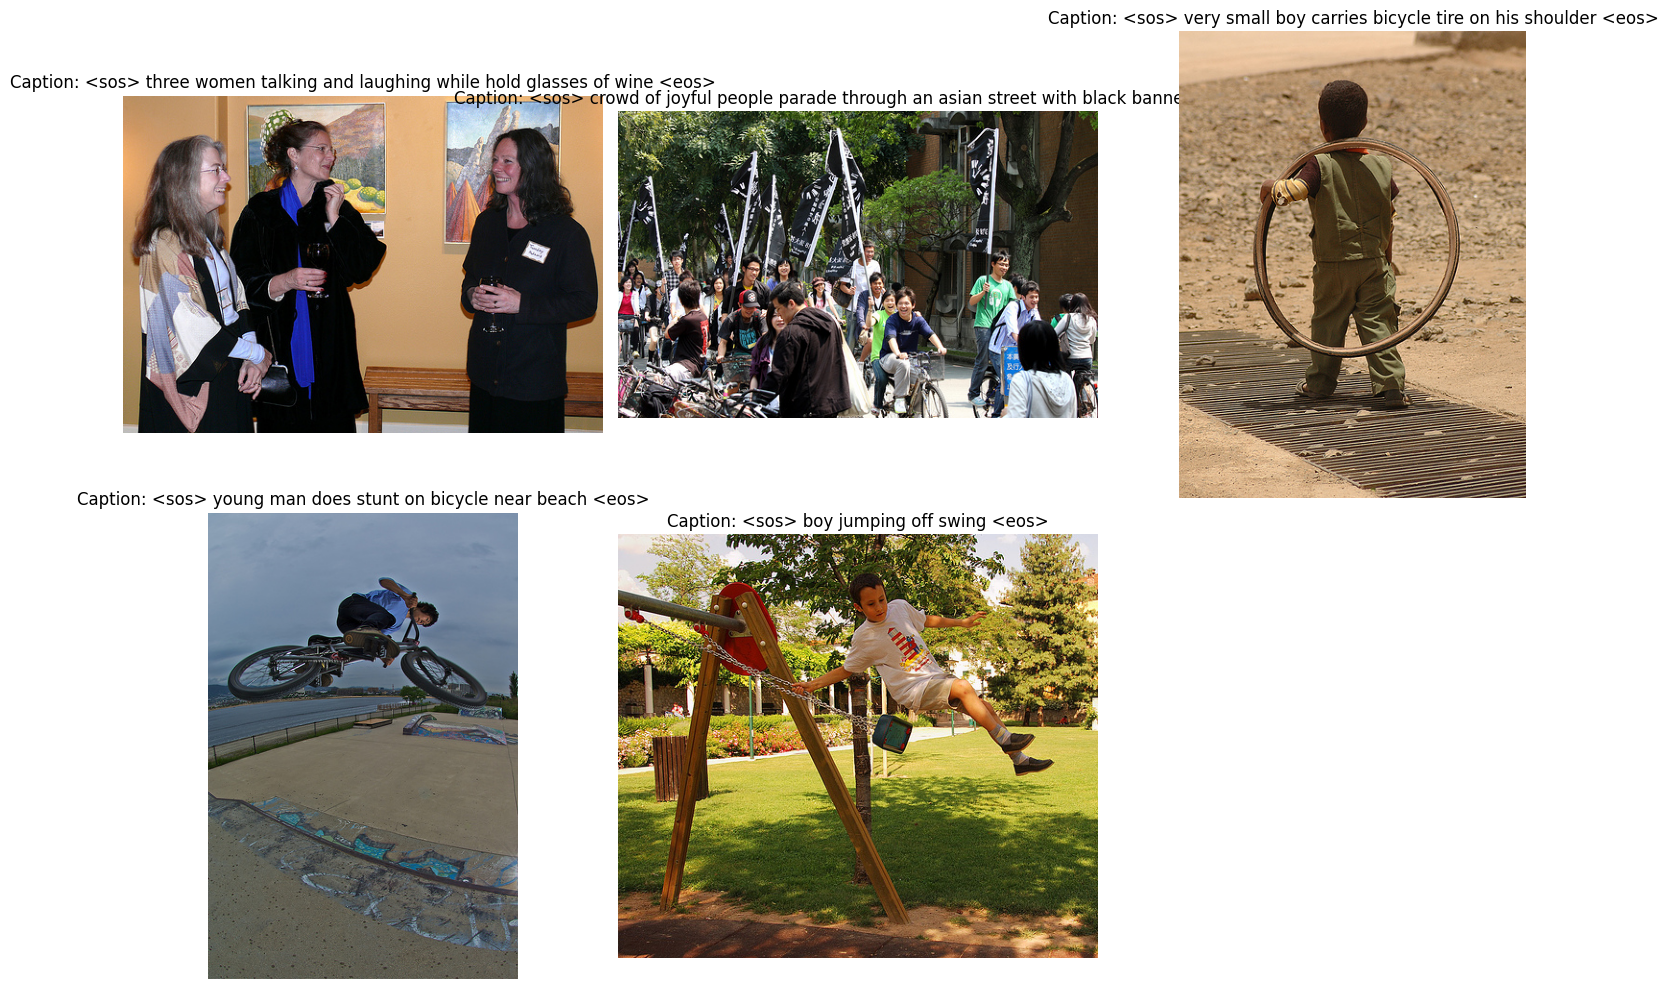

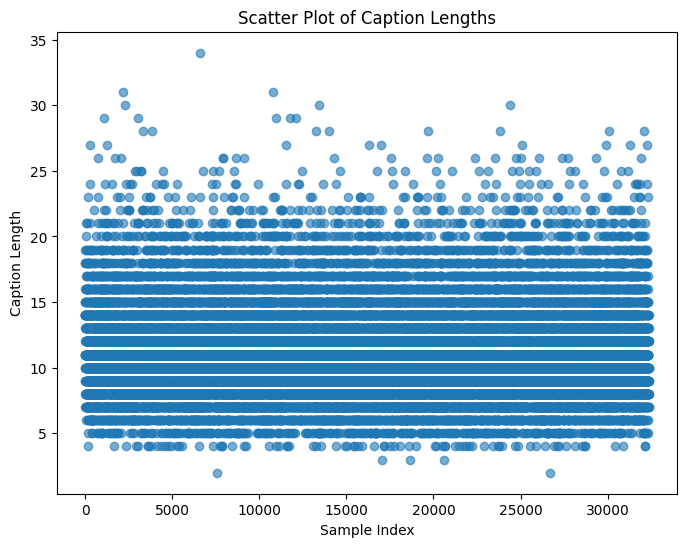

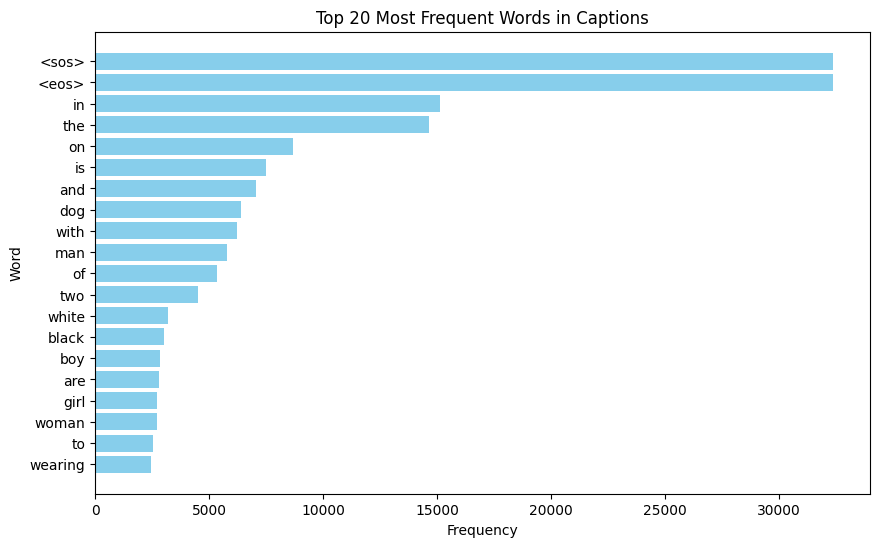

In [12]:
import matplotlib.pyplot as plt
import random
from collections import Counter

# 1. Display 5 random images with captions
random_indices = random.sample(range(len(train_data)), 5)
plt.figure(figsize=(15, 10))

for i, idx in enumerate(random_indices):
    image_path_ = os.path.join(image_path, train_data.loc[idx, 'image'])
    image = plt.imread(image_path_)
    caption = train_data.loc[idx, 'caption']  # Assuming 'caption' column contains the captions

    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Caption: {caption}")

plt.tight_layout()
plt.show()

# 2. Scatter plot of caption lengths
caption_lengths = [len(caption.split()) for caption in train_data['caption']]

plt.figure(figsize=(8, 6))
plt.scatter(range(len(caption_lengths)), caption_lengths, alpha=0.6)
plt.xlabel("Sample Index")
plt.ylabel("Caption Length")
plt.title("Scatter Plot of Caption Lengths")
plt.show()

# 3. Histogram of top 20 most frequent words
all_words = ' '.join(train_data['caption']).split()
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)

words, counts = zip(*most_common_words)

plt.figure(figsize=(10, 6))
plt.barh(words, counts, color='skyblue')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.title("Top 20 Most Frequent Words in Captions")
plt.gca().invert_yaxis()  # To display the most frequent word at the top
plt.show()


In [13]:
model = ResNet50()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature


102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


100%|██████████| 8091/8091 [11:57<00:00, 11.28it/s]


In [16]:
first_key = next(iter(features))
print(f"First key: {first_key}")
print(f"Shape of first value: {features[first_key].shape}")


First key: 1000268201_693b08cb0e.jpg
Shape of first value: (1, 2048)


In [17]:
import pickle

# Save features to a file
with open("./image_features.pkl", "wb") as f:
    pickle.dump(features, f)
    

In [18]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y
        

In [19]:
input1 = Input(shape=(2048,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


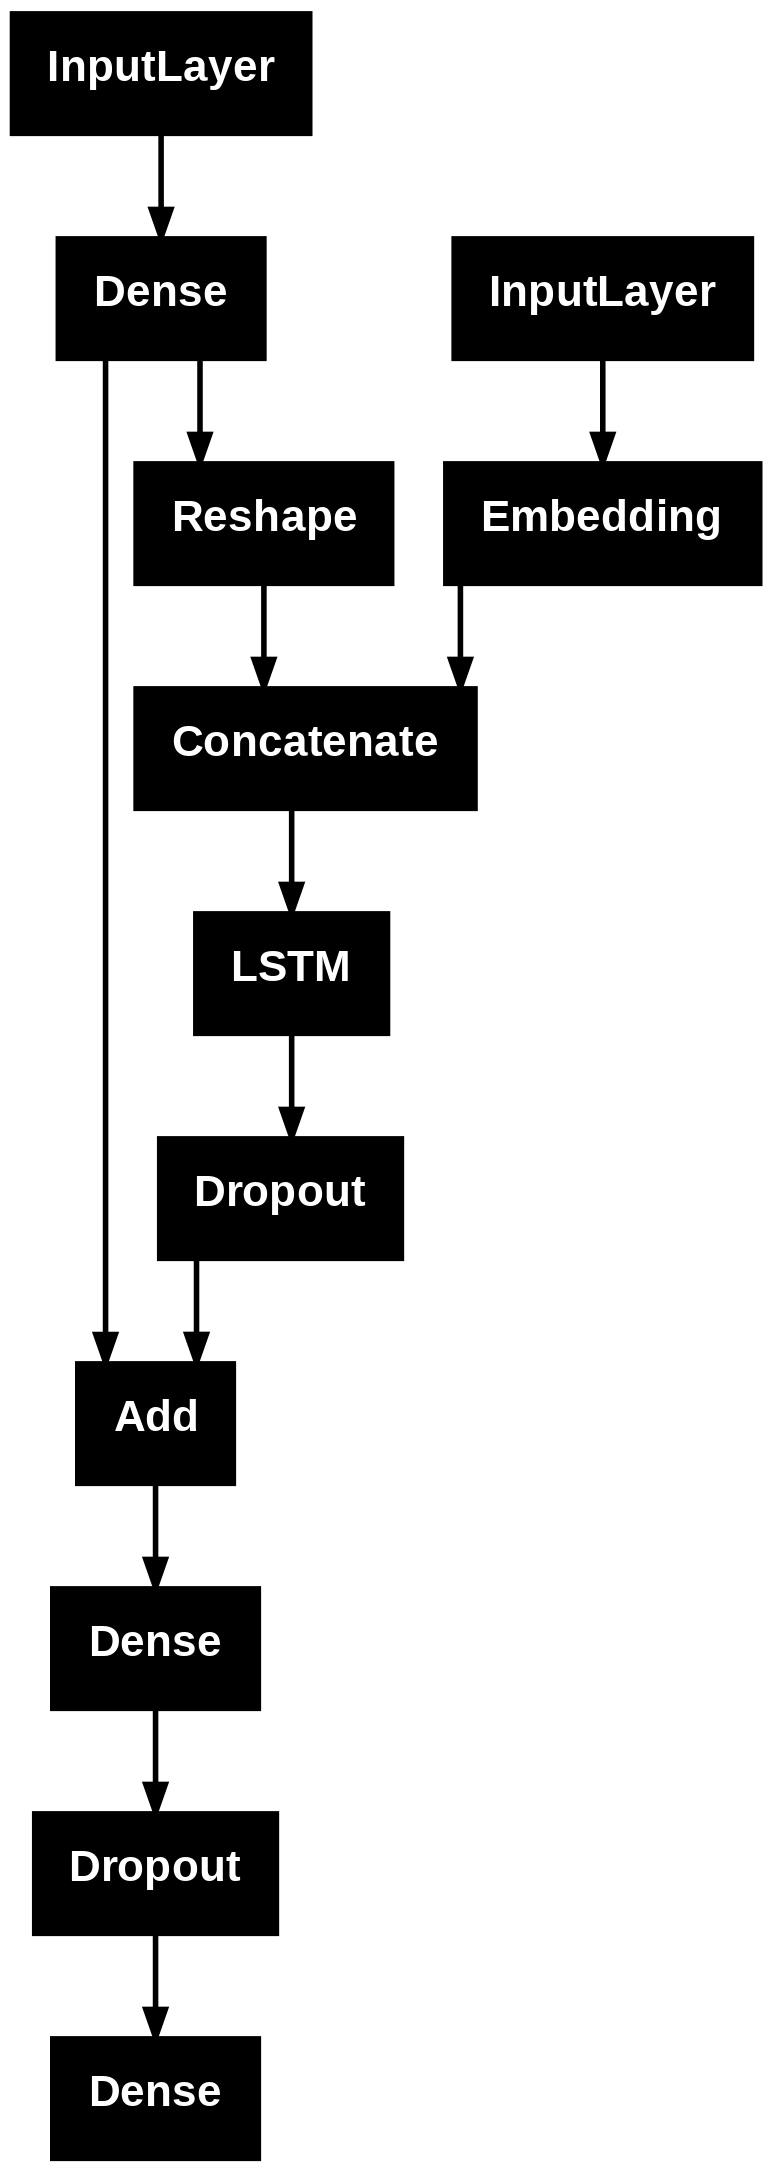

In [20]:
from tensorflow.keras.utils import plot_model

plot_model(caption_model)


In [21]:
caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 35)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 256)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 35, 256)        │      2,172,416 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 36, 256)        │              0 │ reshape[0][0],         │
│                           │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dropout[0][0],         │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8486)           │      1,094,694 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,349,862 (16.59 MB)

 Trainable params: 4,349,862 (16.59 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
train_generator = CustomDataGenerator(df=train_data,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=val_data,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

test_generator = CustomDataGenerator(df=test_data,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [25]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "<sos>"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == '<eos>':
            break
            
    return in_text 
    

In [27]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

class SampleCallback(Callback):
    def __init__(self, test_data, image_path, tokenizer, max_length, features):
        super(SampleCallback, self).__init__()
        self.test_data = test_data
        self.image_path = image_path
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.features = features

    def on_epoch_end(self, epoch, logs=None):
        """
        Runs at the end of each epoch to generate a caption for a sample image.
        """
        print(f"\nEpoch {epoch+1} completed. Generating a sample caption...")

        # Select one random sample
        sample = self.test_data.sample(1).reset_index(drop=True)

        for index, record in sample.iterrows():
            img_path = os.path.join(self.image_path, record['image'])
            img = load_img(img_path, target_size=(224, 224))
            img = img_to_array(img) / 255.0  # Normalize
            
            # Generate caption
            caption = predict_caption(self.model, record['image'], self.tokenizer, self.max_length, self.features)
            print(f"🖼️ Image: {record['image']}")
            print(f"📖 Generated Caption: {caption}")


sample_callback = SampleCallback(test_data, image_path, tokenizer, max_length, features)

model_name = "caption_model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta=0, patience=2, verbose =1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2)


In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping, learning_rate_reduction, sample_callback])


Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - loss: 4.7652
Epoch 1: val_loss improved from inf to 4.28450, saving model to caption_model.keras

🔹 **Epoch 1 completed**. Generating a sample caption...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
🖼️ **Image:** 504385521_6e668691a3.jpg
📖 **Generated Caption:** startseq man in blue shirt is standing on the water endseq
537/537 ━━━━━━━━━━━━━━━━━━━━ 284s 522ms/step - loss: 4.7650 - val_loss: 4.2845 - learning_rate: 0.0010
Epoch 2/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 4.3538
Epoch 2: val_loss improved from 4.28450 to 4.13495, saving model to caption_model.keras

🔹 **Epoch 2 completed**. 

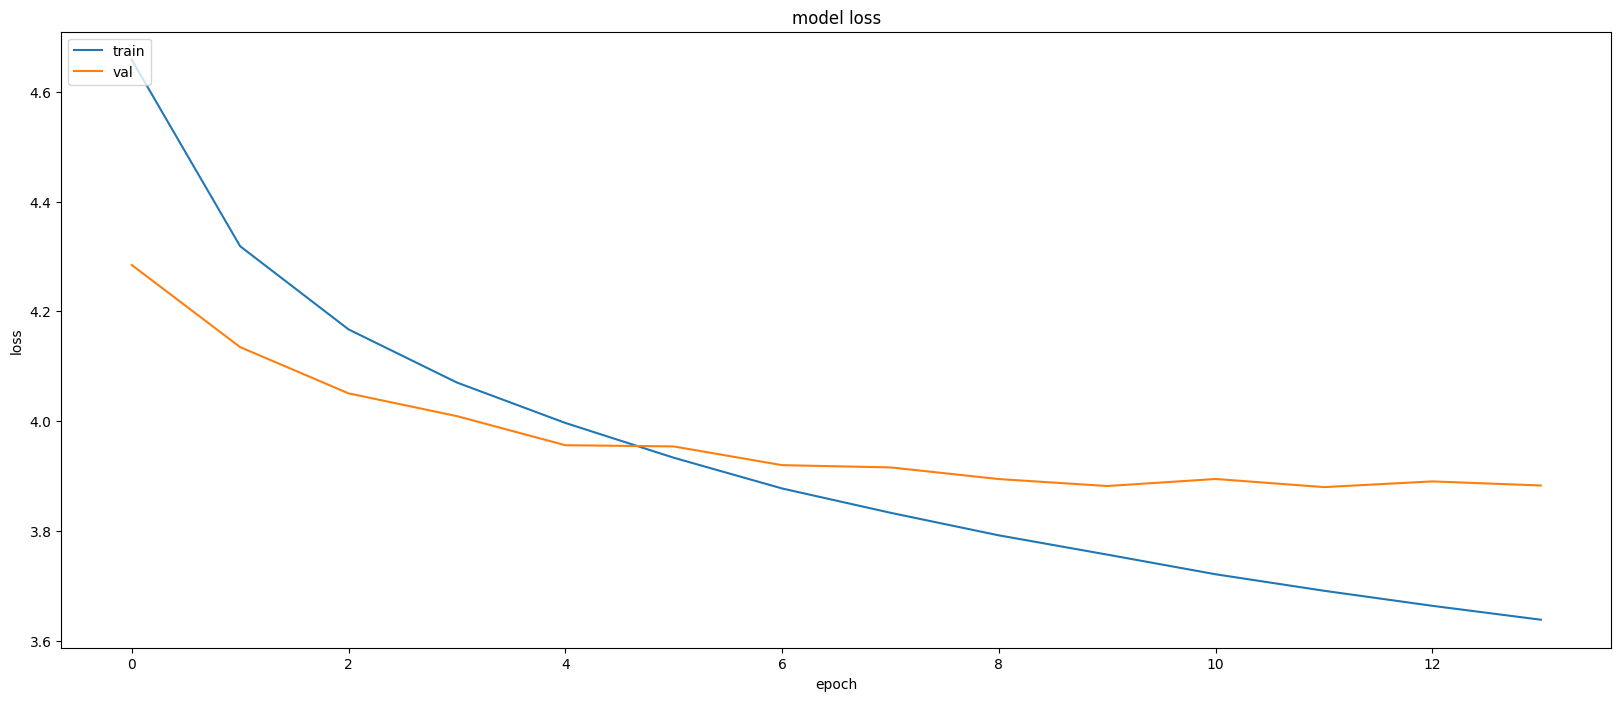

In [79]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [83]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

for index,record in samples.iterrows():
    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

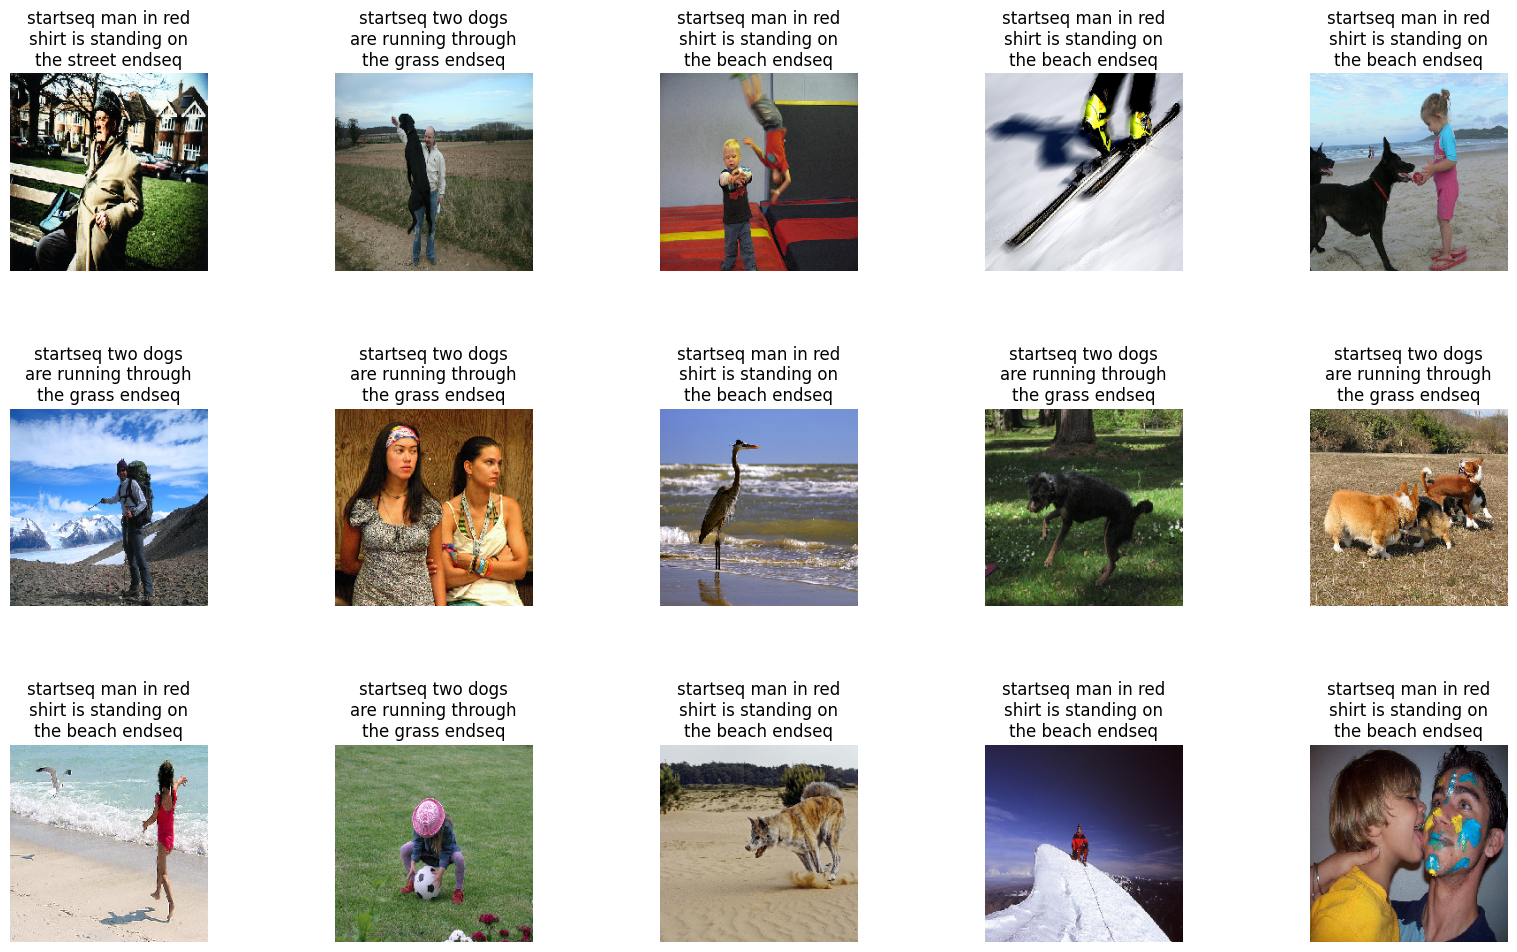

In [84]:
display_images(samples)


In [85]:
def add_positional_encoding(input_tensor, max_length):
    """
    Adds positional encoding to the input tensor.
    """
    position_indices = tf.range(start=0, limit=max_length, delta=1)
    position_encoding = Embedding(input_dim=max_length, output_dim=input_tensor.shape[-1])(position_indices)
    return input_tensor + position_encoding

def add_self_attention(input_sequence, d_model, num_heads, return_attention=True):
    """
    Adds a self-attention mechanism to the decoder.
    """
    # Multi-Head Self-Attention
    attention_layer = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
    
    if return_attention:
        attention_output, attention_scores = attention_layer(input_sequence, input_sequence, return_attention_scores=True)
    else:
        attention_output = attention_layer(input_sequence, input_sequence)
        attention_scores = None

    # Residual Connection & Layer Normalization
    attention_output = Add()([input_sequence, attention_output])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    # Feedforward Layer
    feedforward = Dense(256, activation='relu')(attention_output)
    feedforward_output = Add()([attention_output, feedforward])
    feedforward_output = LayerNormalization(epsilon=1e-6)(feedforward_output)

    return (feedforward_output, attention_scores) if return_attention else feedforward_output


def build_caption_model_with_attention(vocab_size, max_length, cnn_output_dim):
    """
    Builds an image captioning model with an attention mechanism.
    """
    # Encoder (Image Feature Extractor)
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    img_features = Dense(256, activation='relu')(input_image)
    img_features_reshaped = Reshape((1, 256))(img_features)

    # Decoder (Text Sequence Processing)
    input_caption = Input(shape=(max_length,), name='Sequence_Input')
    sentence_features = Embedding(vocab_size, 256, mask_zero=True)(input_caption)

    # Apply Positional Encoding
    sentence_features = add_positional_encoding(sentence_features, max_length)

    # Merge image features and text embeddings
    merged = concatenate([img_features_reshaped, sentence_features], axis=1)

    # LSTM for sequential processing
    lstm_output = LSTM(256, return_sequences=True)(merged)

    # Apply Self-Attention (returns both processed features & attention scores)
    attention_output, attention_scores = add_self_attention(lstm_output, d_model=256, num_heads=4)

    # Pooling to match the final shape
    pooled_attention = GlobalAveragePooling1D()(attention_output)

    # Combine Encoder and Attention Outputs
    decoder_output = Add()([pooled_attention, img_features])
    decoder_output = Dense(128, activation='relu')(decoder_output)
    decoder_output = Dropout(0.5)(decoder_output)

    # Final Prediction Layer
    output = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder_output)

    # Define the Model (Returns both output & attention scores)
    caption_model = Model(inputs=[input_image, input_caption], outputs=[output, attention_scores], name="Caption_Model_With_Attention")
    
    # Compile the Model
    caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

    return caption_model

cnn_output_dim = 2048

attention_model = build_caption_model_with_attention(vocab_size, max_length, cnn_output_dim)
attention_model.summary()


Model: "Caption_Model_With_Attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Features_Input            │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Sequence_Input            │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 256)            │        524,544 │ Features_Input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_16 (Embedding)  │ (None, 34, 256)        │      2,172,160 │ Sequence_Input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_9 (Reshape)       │ (None, 1, 256)         │              0 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_24 (Add)              │ (None, 34, 256)        │              0 │ embedding_16[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_9             │ (None, 35, 256)        │              0 │ reshape_9[0][0],       │
│ (Concatenate)             │                        │                │ add_24[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ (None, 35, 256)        │        525,312 │ concatenate_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_7    │ [(None, 35, 256),      │      1,051,904 │ lstm_8[0][0],          │
│ (MultiHeadAttention)      │ (None, 4, 35, 35)]     │                │ lstm_8[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_25 (Add)              │ (None, 35, 256)        │              0 │ lstm_8[0][0],          │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_12    │ (None, 35, 256)        │            512 │ add_25[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 35, 256)        │         65,792 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_26 (Add)              │ (None, 35, 256)        │              0 │ layer_normalization_1… │
│                           │                        │                │ dense_23[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_13    │ (None, 35, 256)        │            512 │ add_26[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 256)            │              0 │ layer_normalization_1… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├──────────────────────

 Total params: 5,468,197 (20.86 MB)

 Trainable params: 5,468,197 (20.86 MB)

 Non-trainable params: 0 (0.00 B)

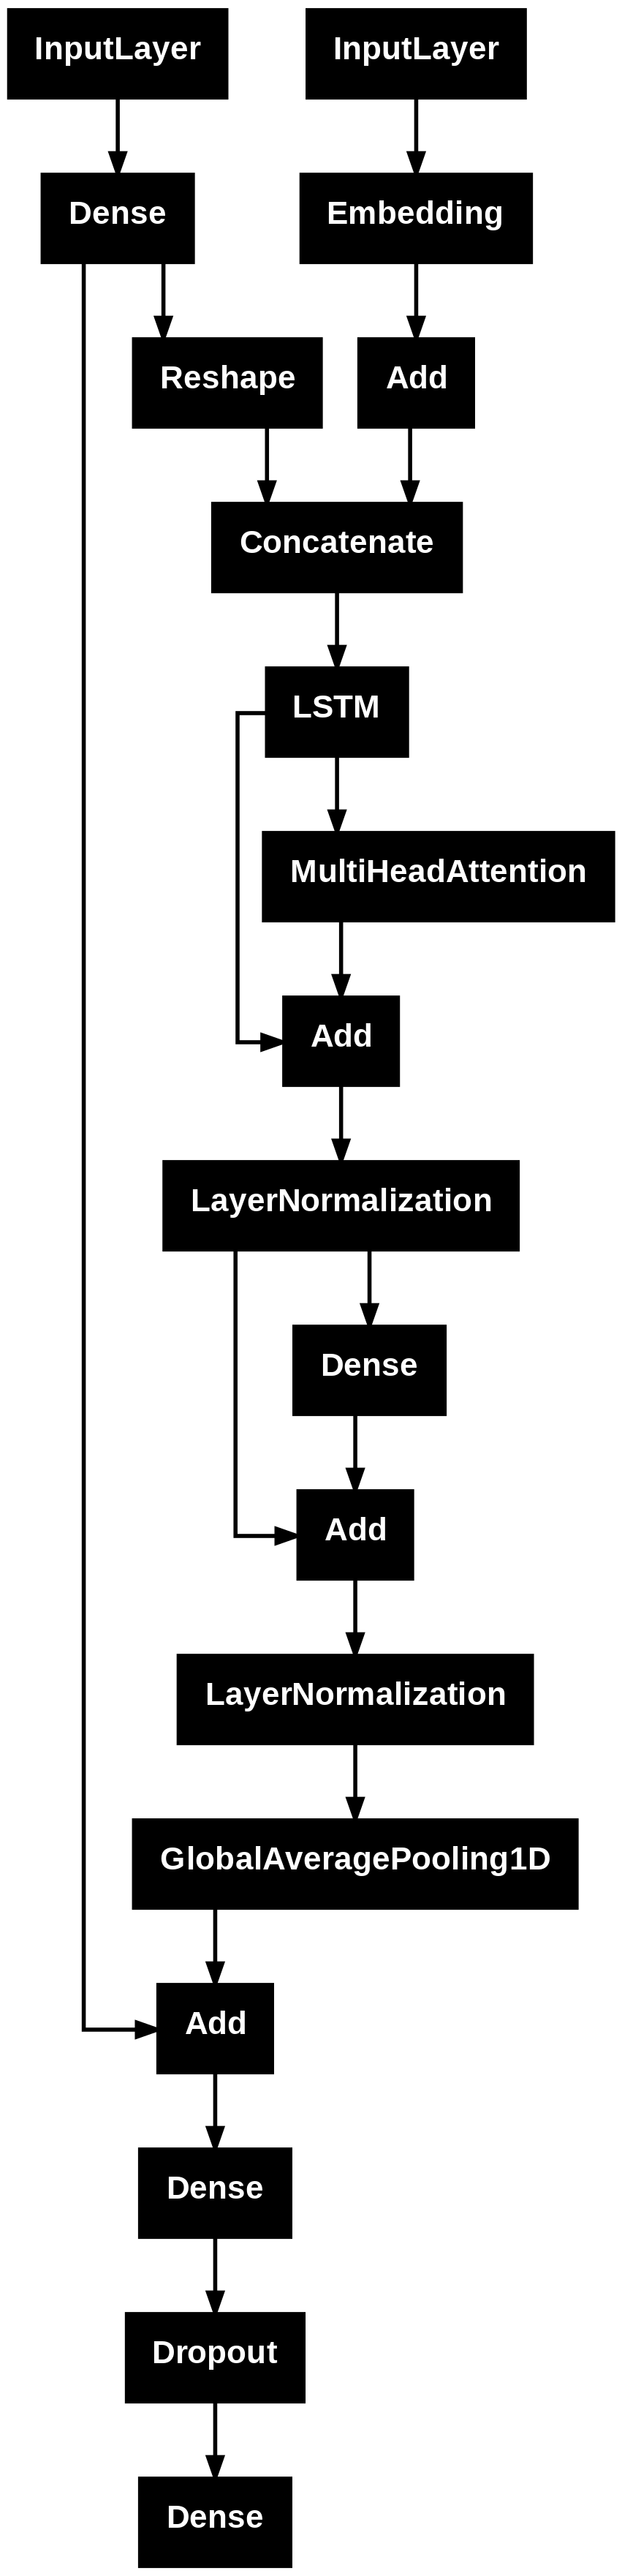

In [86]:
plot_model(attention_model)


In [87]:
model = ResNet50()
model.layers.pop()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature
    

In [88]:
attn_train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

attn_validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)


In [34]:
# Define the model name
model_name = "attention_model.keras"

# Checkpoint: Save the best model based on validation loss
checkpoint = ModelCheckpoint(
    model_name,
    monitor="attn_val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

# EarlyStopping: Stop training if validation loss stops improving
earlystopping = EarlyStopping(
    monitor='attn_val_loss',
    mode="min",
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# ReduceLROnPlateau: Reduce learning rate if validation loss plateaus
learning_rate_reduction = ReduceLROnPlateau(
    monitor='attn_val_loss',
    mode="min",
    patience=3,
    verbose=1,
    factor=0.2
)

# Train the model
attn_history = attention_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]
)

Epoch 1/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 83s 162ms/step - loss: 4.2607 - val_loss: 4.0902 - learning_rate: 0.0010
Epoch 2/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 83s 162ms/step - loss: 4.1023 - val_loss: 4.0278 - learning_rate: 0.0010
Epoch 3/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 84s 164ms/step - loss: 3.7839 - val_loss: 3.9043 - learning_rate: 0.0010
Epoch 6/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 85s 166ms/step - loss: 3.7099 - val_loss: 3.8661 - learning_rate: 0.0010
Epoch 7/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 75s 148ms/step - loss: 3.6447 - val_loss: 3.8687 - learning_rate: 0.0010
Epoch 8/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 84s 165ms/step - loss: 3.5830 - val_loss: 3.8816 - learning_rate: 0.0010
Epoch 9/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 82s 161ms/step - loss: 3.5182 - val_loss: 3.8898 - learning_rate: 0.0010
Epoch 10/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - loss: 3.4699 - val_loss: 3.9108 - learning_rate: 0.0010
Epoch 11/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 84s 164ms/step - loss: 3.4130 - val_loss: 3.9486 - lea

KeyboardInterrupt: 

In [35]:
plt.figure(figsize=(20,8))
plt.plot(attn_history.history['loss'])
plt.plot(attn_history.history['val_loss'])
plt.title('attention model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


NameError: name 'attn_history' is not defined

<Figure size 2000x800 with 0 Axes>

In [36]:
def predict_caption_with_attention(model, image_name, tokenizer, max_length, features):
    """
    Predicts the caption for a given image while extracting attention scores.
    """
    input_img_features = features[image_name]
    input_caption = np.zeros((1, max_length))
    
    generated_caption = []
    all_attention_scores = []

    for i in range(max_length):
        preds, attention_scores = model.predict([input_img_features, input_caption], verbose=0)

        # Ensure `attention_scores` is valid
        if attention_scores.shape[1] <= i:
            print(f"Warning: Attention scores shorter than expected at step {i}")
            break

        # Get the predicted word
        next_word_idx = np.argmax(preds[0, i])  # Ensure predictions align with expected shape
        next_word = tokenizer.index_word.get(next_word_idx)

        if next_word == "endseq" or next_word == "<OOV>":
            break

        generated_caption.append(next_word)
        all_attention_scores.append(attention_scores[0, i])  # Store attention map
        
        input_caption[0, i] = next_word_idx  # Update input for next iteration
    
    return " ".join(generated_caption), np.array(all_attention_scores)

from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def idx_to_word(integer, tokenizer):
    """
    Convert a predicted index into a word.
    """
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length, features):
    """
    Predict the caption for a given image.
    """
    feature = features[image]
    in_text = "<sos>"
    
    for i in range(max_length):
        # Convert text to sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding="post")

        # Get model prediction (handling multiple outputs)
        y_pred = model.predict([feature, sequence], verbose=0)
        if isinstance(y_pred, (list, tuple)):  # If the model returns multiple outputs (e.g., attention scores)
            y_pred = y_pred[0]  # Extract only the first output (word prediction)

        # Ensure correct shape before argmax
        y_pred = np.squeeze(y_pred)  # Remove unnecessary dimensions
        y_pred = np.argmax(y_pred, axis=-1)  # Get predicted word index
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text += " " + word
        
        if word == "<eos>":
            break
            
    return in_text


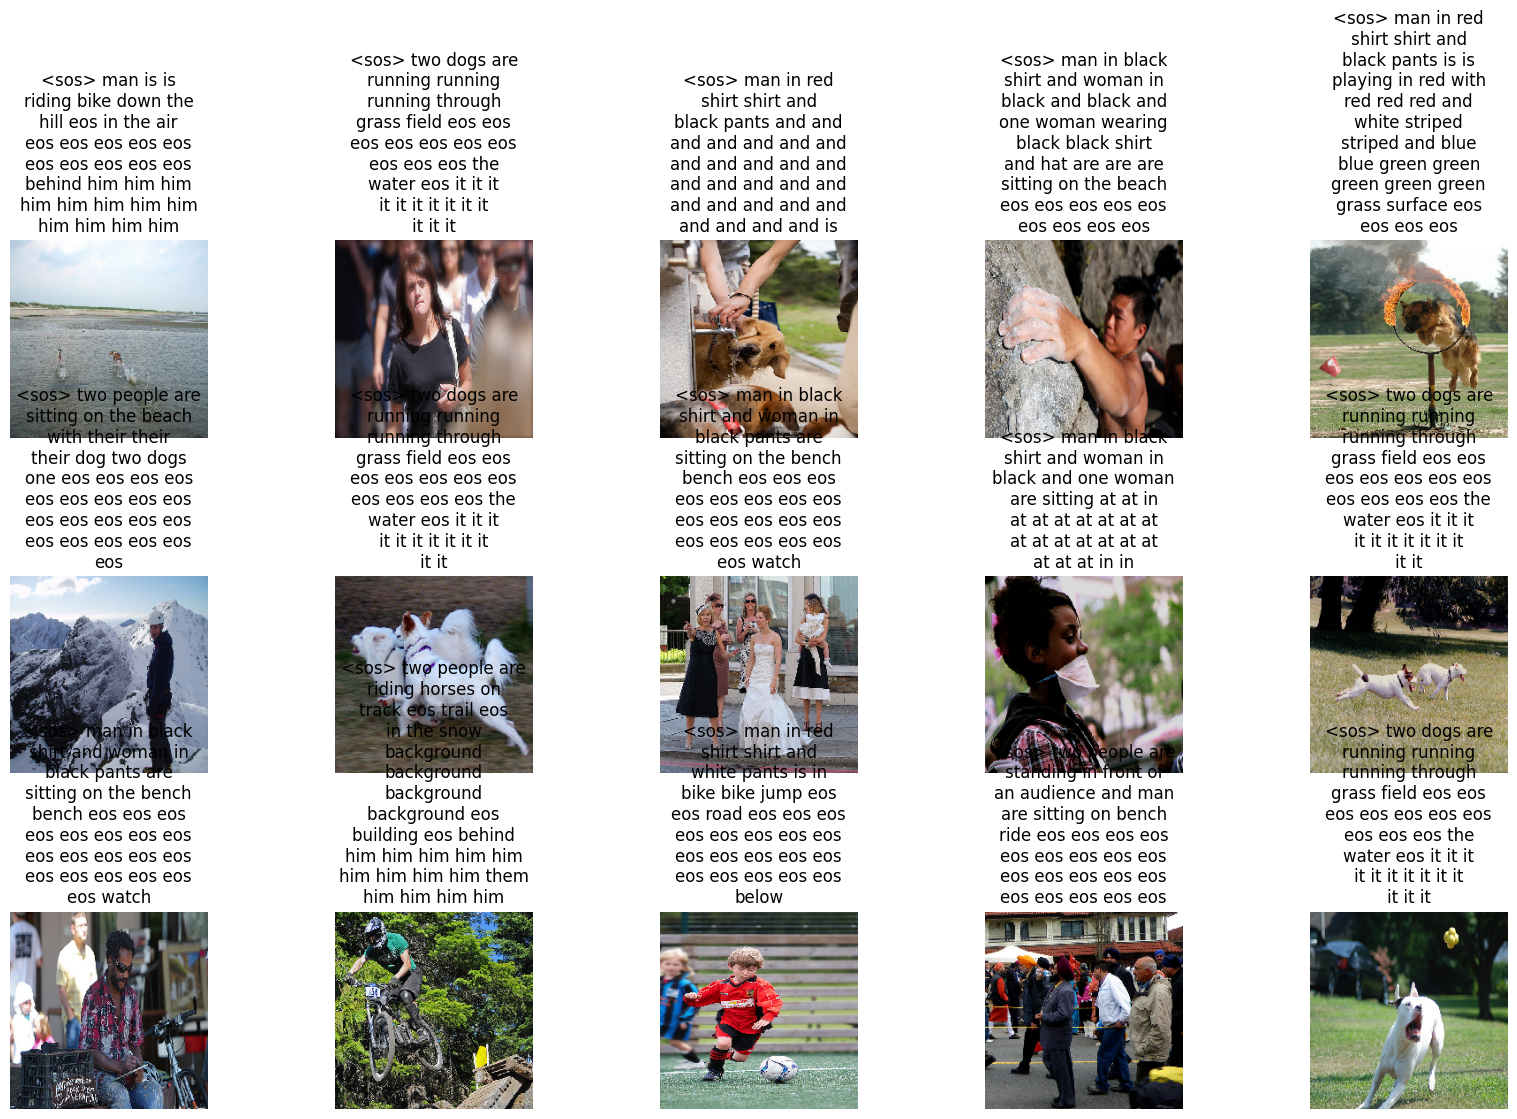

In [38]:
samples = data.sample(15)

for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(attention_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

display_images(samples)


# Masked Tokenizer

In [39]:
# Tokenization with special tokens and OOV handling
tokenizer = Tokenizer(oov_token="<unk>")  # Handle out-of-vocabulary words
tokenizer.fit_on_texts(captions)

# Add special tokens
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

vocab_size = len(tokenizer.word_index)
print(f"Vocabulary size (including special tokens): {vocab_size}")

# Save tokenizer to JSON (useful for later reuse)
with open('tokenizer.json', 'w') as f:
    json.dump(tokenizer.to_json(), f)

# Convert captions to sequences and pad them
sequences = tokenizer.texts_to_sequences(captions)
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

print(f"Max sequence length: {max_length}")

# Create the embedding layer with masking enabled
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=256,  # Adjustable embedding size
    mask_zero=True  # Enable masking of padding tokens
)

# Splitting the data into 80-10-10 for train, validation, and test sets
images = np.array(data['image'].unique())
n_images = len(images)

# Shuffle images before splitting
np.random.seed(42)
np.random.shuffle(images)

train_split = int(0.8 * n_images)
val_split = int(0.9 * n_images)

train_images = images[:train_split]
val_images = images[train_split:val_split]
test_images = images[val_split:]

# Create train, validation, and test datasets
train_data = data[data['image'].isin(train_images)].reset_index(drop=True)
val_data = data[data['image'].isin(val_images)].reset_index(drop=True)
test_data = data[data['image'].isin(test_images)].reset_index(drop=True)

# Ensure there is no overlap between sets
assert len(set(train_images) & set(val_images)) == 0, "Overlap found between train and val sets"
assert len(set(val_images) & set(test_images)) == 0, "Overlap found between val and test sets"
assert len(set(train_images) & set(test_images)) == 0, "Overlap found between train and test sets"

print("Data successfully split into train, validation, and test sets.")
print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

# Example conversion to token sequence
print(tokenizer.texts_to_sequences([captions[1]])[0])


Vocabulary size (including special tokens): 8486
Max sequence length: 35
Data successfully split into train, validation, and test sets.
Train set size: 32360
Validation set size: 4045
Test set size: 4050
[2, 19, 316, 64, 196, 117, 3]


In [13]:
model = ResNet50()
model.layers.pop()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature


attn_train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

attn_validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)


102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


100%|██████████| 8091/8091 [11:57<00:00, 11.28it/s]
